Now that we know which models are performing better, it's time to perform cross validation and tune hyperparameters.
- Do a google search for hyperparameter ranges for each type of model.

GridSearch/RandomSearch are a great methods for checking off both of these tasks.
- BUT we have a problem - if we calculated a numerical value to encode city (such as the mean of sale prices in that city) on the training data, we can't cross validate 
- The rows in each validation fold were part of the original calculation of the mean for that city - that means we're leaking information!
- While sklearn's built in functions are extremely useful, sometimes it is necessary to do things ourselves

You need to create two functions to replicate what Gridsearch does under the hood

**`custom_cross_validation()`**
- Should take the training data, and divide it into multiple train/validation splits. 
- Look into `sklearn.model_selection.KFold` to accomplish this - the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) shows how to split a dataframe and loop through the indexes of your split data. 
- Within your function, you should compute the city means on the training folds just like you did in Notebook 1 - you may have to re-join the city column to do this - and then join these values to the validation fold

**`hyperparameter_search()`**
- Should take the validation and training splits from your previous function, along with your dictionary of hyperparameter values
- For each set of hyperparameter values, fit your chosen model on each set of training folds, and take the average of your chosen scoring metric. [itertools.product()](https://docs.python.org/3/library/itertools.html) will be helpful for looping through all combinations of hyperparameter values
- Your function should output the hyperparameter values corresponding the highest average score across all folds. Alternatively, it could also output a model object fit on the full training dataset with these parameters.

Docstrings have been provided below to get you started. Once you're done developing your functions, you should move them to `functions_variables.py` to keep your notebook clean 

Bear in mind that these instructions are just one way to tackle this problem - the inputs and output formats don't need to be exactly as specified here.

XGBOOST

In [325]:
import pandas as pd
from sklearn.model_selection import KFold

def custom_cross_validation(training_data, n_splits=5):
    # Initialize KFold

    kf = KFold(n_splits=n_splits)

    # Lists to store training and validation folds

    training_folds = []
    validation_folds = []
    
    # Iterate over each fold

    for train_index, val_index in kf.split(training_data):
        # Split data into train and validation sets

        train_fold = training_data.iloc[train_index]
        val_fold = training_data.iloc[val_index]
        
        # Compute city means on the training fold

        city_means = train_fold.groupby('city')['list_price'].mean().reset_index()
        city_means.columns = ['city', 'city_mean']
        
        # Join city means to validation fold

        val_fold = pd.merge(val_fold, city_means, on='city', how='left')
        
        # Append training and validation folds to lists
        
        training_folds.append(train_fold)
        validation_folds.append(val_fold)
    
    return training_folds, validation_folds

In [326]:
import itertools

def hyperparameter_search(training_folds, validation_folds, hyperparameter_values, model):
    # Initialize variables to store best hyperparameters and corresponding score

    best_hyperparameters = None
    best_score = float('-inf')
    
    # Loop through all combinations of hyperparameter values

    for hyperparameters in itertools.product(*hyperparameter_values.values()):
        # Create a dictionary of hyperparameter names and values
        
        hyperparameter_dict = dict(zip(hyperparameter_values.keys(), hyperparameters))
        
        # Initialize variable to store average score across folds

        average_score = 0
        
        # Iterate over each fold

        for train_fold, val_fold in zip(training_folds, validation_folds):
            # Extract features and target from training and validation folds

            X_train = train_fold.drop(columns=['target'])
            y_train = train_fold['target']
            X_val = val_fold.drop(columns=['target'])
            y_val = val_fold['target']
            
            # Create model instance with current hyperparameters

            current_model = model(**hyperparameter_dict)
            
            # Fit model on training data

            current_model.fit(X_train, y_train)
            
            # Make predictions on validation data

            y_pred = current_model.predict(X_val)
            
            # Calculate score using chosen metric (e.g., mean squared error)

            score = mean_squared_error(y_val, y_pred) 
            
            # Update average score

            average_score += score / len(validation_folds)
        
        # Check if current hyperparameters yield a better score
        
        if average_score > best_score:
            best_score = average_score
            best_hyperparameters = hyperparameter_dict
    
    return best_hyperparameters


SVR REGRESSOR

In [310]:
def custom_cross_validation_svr(training_data, n_splits=5):
    kf = KFold(n_splits=n_splits)
    svr_training_folds = []
    svr_validation_folds = []
    
    for train_index, val_index in kf.split(training_data):
        train_fold = training_data.iloc[train_index]
        val_fold = training_data.iloc[val_index]
        
        city_means = train_fold.groupby('city')['target'].mean().reset_index()
        city_means.columns = ['city', 'city_mean']
        
        val_fold = pd.merge(val_fold, city_means, on='city', how='left')
        
        svr_training_folds.append(train_fold)
        svr_validation_folds.append(val_fold)
    
    return svr_training_folds, svr_validation_folds


In [311]:
import itertools
from sklearn.svm import SVR
from sklearn.metrics import r2_score

def hyperparameter_search_svr(training_folds, validation_folds, param_grid):
    best_hyperparameters = None
    best_score = float('-inf')
    
    for params in itertools.product(*param_grid.values()):
        total_score = 0
        for i in range(len(training_folds)):
            model = SVR(**dict(zip(param_grid.keys(), params)))
            model.fit(training_folds[i].drop(columns=['target', 'city']), training_folds[i]['target'])
            y_pred = model.predict(validation_folds[i].drop(columns=['target', 'city']))
            score = r2_score(validation_folds[i]['target'], y_pred)
            total_score += score
        
        average_score = total_score / len(training_folds)
        if average_score > best_score:
            best_score = average_score
            best_hyperparameters = params
    
    return best_hyperparameters

We want to make sure that we save our models.  In the old days, one just simply pickled (serialized) the model.  Now, however, certain model types have their own save format.  If the model is from sklearn, it can be pickled, if it's xgboost, for example, the newest format to save it in is JSON, but it can also be pickled.  It's a good idea to stay with the most current methods. 
- you may want to create a new `models/` subdirectory in your repo to stay organized

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

In [391]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
import pandas as pd
import os

# Custom transformer function for loading and preprocessing data

def load_and_preprocess_data(data_path):
    # Load CSV data

    df = pd.read_csv(data_path)
    return df

# Function to make predictions using the loaded model

def predict_with_model(X, model_path):
    # Load the saved model

    model = XGBRegressor()
    model.load_model(model_path)
    return model.predict(X)

# Get the parent directory of the current working directory

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Construct the full path to the CSV file

data_path = os.path.join(parent_dir, 'data', 'processed', 'x_test.csv')

# Construct the full path to the XGBoost model file

model_path = os.path.join(parent_dir, 'models', 'xgboost_model.model')

# Create a pipeline

pipeline = Pipeline([
    ('load_and_preprocess', FunctionTransformer(load_and_preprocess_data)),
    ('predict', FunctionTransformer(predict_with_model, kw_args={'model_path': model_path}))
])

# Test the pipeline with original data

try:
    predictions = pipeline.transform(data_path)
    print("Predictions:", predictions)
except Exception as e:
    print("An error occurred:", e)


Predictions: [212.00002   180.36714    71.57536   212.00002   212.00002    65.34403
   1.3224132 212.00002   212.00002    70.40838    97.386375  212.00002
  81.24224   212.00002   193.81508   126.91804   197.62462   152.95367
 114.56613    89.24013   212.00002   212.00002    70.418      77.850006
 188.31549   212.00002   212.00002   212.00002    18.489634  145.49324
 206.45055    97.386375  212.00002   212.00002   113.503174  212.00002
  75.236916   66.16294   212.00002   146.76859   212.00002    20.853241
  48.267757  152.3542    212.00002   212.00002   147.29456   212.00002
  54.761047  108.09569   170.12332   212.00002   212.00002   137.88205
 212.00002    72.54093   212.00002    25.33888    69.501595  143.73445
 212.00002   212.00002   108.70021    43.695885  167.22116   212.00002
 100.70514   179.41112   132.59624    76.211525  212.00002    83.66373
 212.00002    82.570465   49.23465    84.368835  212.00002   212.00002
 212.00002   212.00002   152.95367   212.00002   212.00002   1

Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

In [392]:
# save your pipeline here

import pickle

pipeline_path = '../models/pipeline.pkl'

# Save the pipeline

with open(pipeline_path, 'wb') as f:
    pickle.dump(pipeline, f)


<Figure size 1000x600 with 0 Axes>

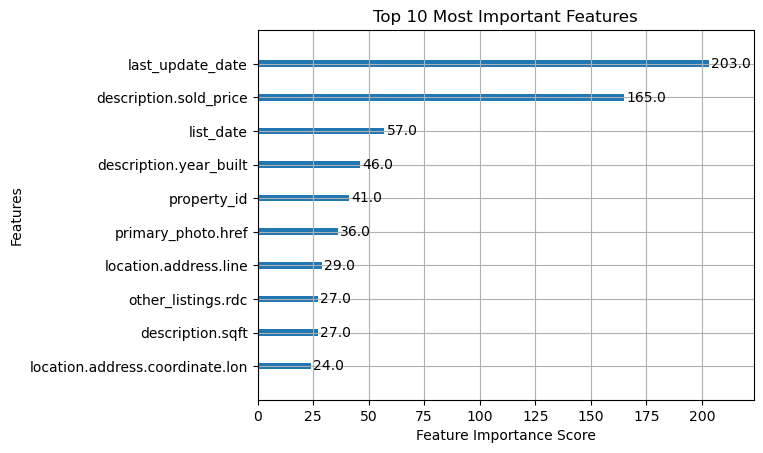

In [412]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# Load the xgboost_model from the previous notebook

%store -r xgboost_model

# Plot feature importance

plt.figure(figsize=(10, 6))
plot_importance(xgboost_model, max_num_features=10)  # You can adjust max_num_features as needed
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()
